In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm

from pyPSFstack.pupils.sources import DipoleInterfaceSource
from pyPSFstack.pupils.windows import SEO
from pyPSFstack.pupils.aberrations import UnitaryAberrations
from pyPSFstack.core import PSFStack
from pyPSFstack.functions import trim_stack
from pyPSFstack.diversities.pola_diversities import PDiversity_QWP, \
    PDiversity_LP, PDiversity_Compound
from pyPSFstack.diversities.pupil_diversities import ZDiversity
from pyPSFstack.blurring import ExactBlurring

# from pyPSFstack_torch.psf_modules import IncoherentPSF#,ScalarPhaseAberrations,\
    # ScalarPSF
from pyPSFstack_torch.psf_modules import torchPSFStack
from pyPSFstack_torch.diversities.pola_diversities import torchPDiversity_QWP, \
    torchPDiversity_LP, torchPDiversity_Compound

In [3]:

# from pyPSFstack_torch.sources import DipoleInterfaceSource
# from pyPSFstack_torch.windows import SEO
# from pyPSFstack_torch.aberrations import UnitaryPolarizationAberrations
# from pyPSFstack_torch.diversities import ZDiversity, PDiversity
# from pyPSFstack_torch.functions import polar_mesh, xy_mesh
# from pyPSFstack_torch.functions import crop_center

# Numerical experiments for characterizing a birefringent window from a PSF stack

## 1. Definition for the creation of simulated data

### 1.1 Parameter definition

In [4]:
# Define number of points use for the computation 
N_pts = 128
# Experimental parameters
numerical_aperture = 1.49
magnification = 100
ni = 1.33
nf = 1.518
cam_pixel_size = 6500
radius = 10
wavelength = 525
dipole_orientation = [0,0,0] # this means incoherent
# Define positions of defocus
zi = -500; zf = 500; z_step = 100
z_list = torch.arange(zi,zf+z_step,z_step) 
# Define rotation angles of polarization analyzer
angle_i = 0; angle_f = np.pi/2; angle_step = np.pi/8
angle_list=np.arange(angle_i,angle_f,angle_step)

We put all the parameters in a dictionary 

In [5]:
params = {}
params['pupil'] = {}
params['pupil']['aperture_size'] = numerical_aperture / nf
params['pupil']['computation_size'] = wavelength*magnification/(cam_pixel_size*nf)
params['pupil']['N_pts'] = N_pts

params['source'] = {}
params['source']['ni'] = ni
params['source']['nf'] = nf
params['source']['delta'] = radius/wavelength

params['window'] = {}
params['window']['c'] = np.pi#1.24*np.pi

params['zdiversity'] = {}
params['zdiversity']['z_list'] = z_list / wavelength
params['zdiversity']['nf'] = nf

params['blurring'] = {}
params['blurring']['ni'] = ni
params['blurring']['nf'] = nf
params['blurring']['radius'] = radius/wavelength
params['blurring']['diff_del_list'] = np.linspace(-radius/wavelength,
    radius/wavelength,8)[1:-1] 

### 1.2 PSF computation

Instantiate all the class elements need to define a PSF stack

In [6]:
# The source and window define th epupil sequence
src = DipoleInterfaceSource(**params['pupil'],**params['source'])
wdw = SEO(**params['pupil'],**params['window'])
pupil_sequence = [src, wdw]
# Then the diversities
zdiv = ZDiversity(**params['zdiversity'], **params['pupil'])
# The polarization diversity is taken as a rotating QWP followed 
# by a wollastan which splits into horizontal and vertical polarized
# light 
qwp = PDiversity_QWP(angle_list)
wollaston = PDiversity_LP([0, np.pi/2])
pdiv = PDiversity_Compound([qwp, wollaston])
# Finally we define the blurring as the exact model to try
# to mimic the experimental result
blurring = ExactBlurring(**params['blurring'],**params['pupil'])

Finally, compute the modelled PSF stack

In [7]:
psfs = PSFStack(pupil_sequence, zdiversity=zdiv, pdiversity=pdiv, blurring=blurring)
psfs.compute_psf_stack(orientation=[0,0,0])

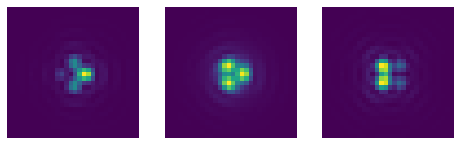

In [8]:
zdiv_mid_ind = int((zf-zi)/z_step//2)
stack = trim_stack(psfs.psf_stack, 30)
fig, ax = plt.subplots(1,3,figsize=(8,8))
for ind in range(3):
    ax[ind].imshow(stack[...,zdiv_mid_ind-1,ind])
    ax[ind].set_axis_off()

### 1.3 Model experimental stack

In [9]:
data_stack = psfs.model_experimental_stack(bckgd_photons=0,N_photons=5000,N_pts=30)

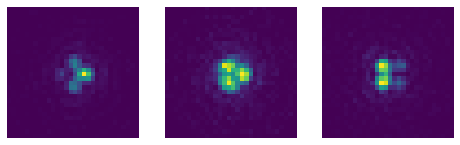

In [10]:
zdiv_mid_ind = int((zf-zi)/z_step//2)
fig, ax = plt.subplots(1,3,figsize=(8,8))
for ind in range(3):
    ax[ind].imshow(data_stack[...,zdiv_mid_ind-1,ind])
    ax[ind].set_axis_off()

## 2. Birefringent window characterization

In [11]:
from pyPSFstack_torch.pupils.sources import torchDipoleInterfaceSource
from pyPSFstack_torch.pupils.windows import SEO
from pyPSFstack_torch.pupils.aberrations import torchUnitaryAberrations
# from .diversities.diversities import PDiversity#, ZDiversity
from pyPSFstack_torch.diversities.pupil_diversities import torchZDiversity

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
# The source and window define th epupil sequence
tsrc = torchDipoleInterfaceSource(**params['pupil'],**params['source'])
twdw = torchUnitaryAberrations(**params['pupil'])
tpupil_sequence = [tsrc, twdw]
# Then the diversities
tzdiv = torchZDiversity(**params['zdiversity'], **params['pupil'])
# The polarization diversity is taken as a rotating QWP followed 
# by a wollastan which splits into horizontal and vertical polarized
# light 
torch_pdiv = torchPDiversity_Compound([torchPDiversity_QWP(angle_list), 
    torchPDiversity_LP([0, np.pi/2])])

/opt/anaconda3/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272480871/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/Users/rodrigo/Documents/Research/CHIDO/pyPSFstack/pyPSFstack_torch/diversities/pupil_diversities.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.z_list = torch.reshape(torch.tensor(z_list), (1,1,-1))


In [14]:
model_retrieved = torchPSFStack(
                 tpupil_sequence,
                 zdiversity=tzdiv,
                 pdiversity=torch_pdiv 
                 )

In [15]:
model_retrieved = torchPSFStack(
                 pdiversity=torch_pdiv,
                 aperture_size=numerical_aperture / nf, 
                 computation_size=wavelength*magnification/(cam_pixel_size*nf), 
                 N_pts=128, 
                 ni=ni, 
                 nf=nf, 
                 delta=0.1,
                 jmax=[15]*5, 
                 index_convention='fringe', z_list=z_list/wavelength
                 )

TypeError: __init__() got an unexpected keyword argument 'aperture_size'

In [15]:
with torch.no_grad():
    model_retrieved.eval()
    first_est = model_retrieved(30)

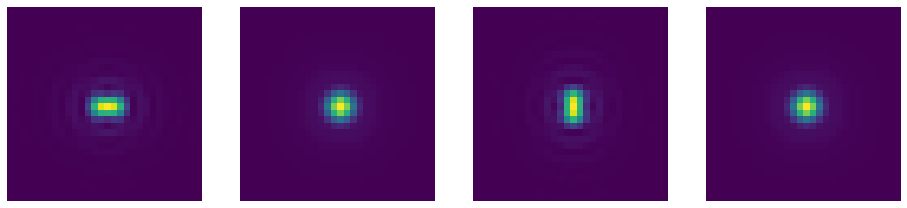

In [21]:
fig, ax = plt.subplots(1,4,figsize=(16,4))
for ind in range(4):
    ax[ind].imshow(first_est[...,5,ind])
    ax[ind].set_axis_off()

In [23]:
model_retrieved.parameters()

<generator object Module.parameters at 0x7fe586bad450>

### 2.2 Define optimization parameters

In [24]:
lr = 1e-2
n_epochs = 500

loss_fn = nn.MSELoss(reduction='mean')
# optimizer = optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(
    model_retrieved.parameters(), 
    lr=lr
)

data = torch.from_numpy(data_stack).type(torch.float)
data *= torch.mean(first_est)/torch.mean(data)

ValueError: optimizer got an empty parameter list

In [72]:

loss_evol =[]
for epoch in tqdm(range(n_epochs)):
    
    model_retrieved.train()
    yhat = model_retrieved(30)
    
    loss = loss_fn(data, yhat)
    loss_evol += [loss.item()]
    loss.backward()    
    optimizer.step()
    optimizer.zero_grad()
    # if epoch%100==0:
    #     print(epoch)

100%|██████████| 500/500 [00:55<00:00,  8.96it/s]


In [18]:
def get_param_dict(model):
    dic = {}
    state = model.state_dict()
    for name in state.keys():
        dic[name] = torch.Tensor.cpu(state[name]).numpy()
    return dic

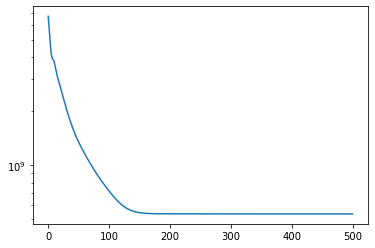

In [73]:
plt.plot(loss_evol)
plt.gca().set_yscale('log')

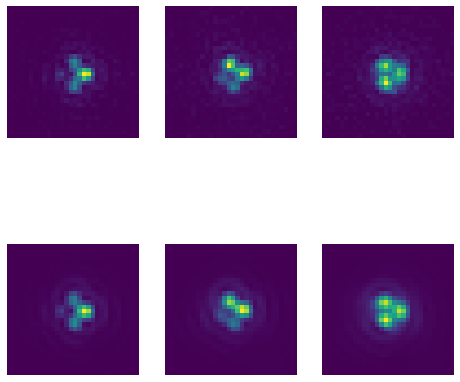

In [78]:
zdiv_mid_ind = int((zf-zi)/z_step//2)
ret_stack = yhat.detach()
fig, ax = plt.subplots(2,3,figsize=(8,8))
for ind in range(3):
    ax[0,ind].imshow(data_stack[...,zdiv_mid_ind-1,ind])
    ax[0,ind].set_axis_off()
    ax[1,ind].imshow(ret_stack[...,zdiv_mid_ind-1,ind])
    ax[1,ind].set_axis_off()

In [74]:
abe = UnitaryAberrations(**params['pupil'], **get_param_dict(model_retrieved.aberrations))

In [76]:
get_param_dict(model_retrieved.source)

{'alpha': array(0.30487138, dtype=float32)}

In [77]:
(nf/ni)**3

1.4868268381395007

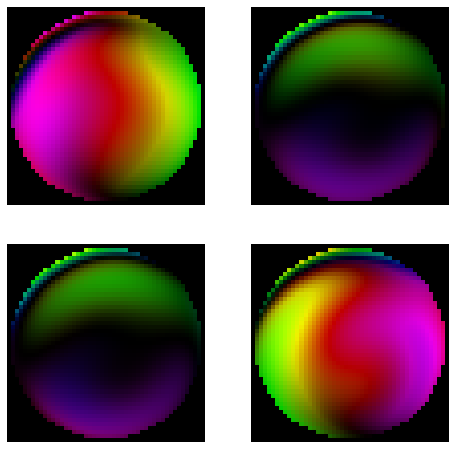

In [75]:
abe.plot_pupil_field()

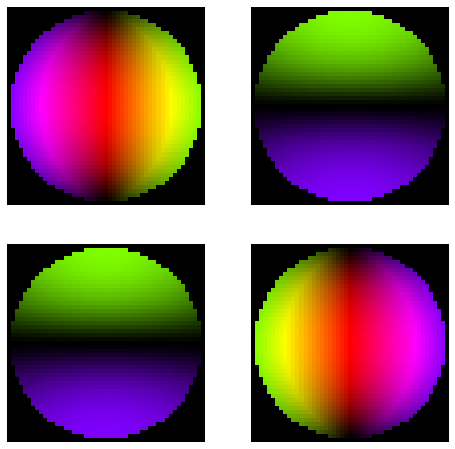

In [40]:
wdw.plot_pupil_field()

# Old stuff

This is done by adding background illumination and Poisson noise. The stack is first normalized with respect to the average number of photons hitting the camera for each PSF image.

In [6]:
source = DipoleInterfaceSource(aperture_size=aperture_size,
 computation_size=computation_size, 
                 N_pts=128, ni=1.33, nf=1.518, delta=0.1)
seo = SEO(aperture_size=aperture_size,
 computation_size=computation_size, 
                 N_pts=128)
aberrations = UnitaryPolarizationAberrations(aperture_size=aperture_size, computation_size=computation_size, 
                 N_pts=128, jmax=[15]*5, index_convention='fringe')
zdiv = ZDiversity(aperture_size=aperture_size,
 computation_size=computation_size, 
                 N_pts=128)

/opt/anaconda3/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272480871/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/Users/rodrigo/Documents/Research/CHIDO/pyPSFstack/pyPSFstack_torch/sources.py:65: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272480871/work/aten/src/ATen/native/Copy.cpp:244.)
  aperture = self.ur2.type(torch.float) <= aperture_size**2


In [7]:
model_measured = IncoherentPSF(
                 pol_analyzer='quarter2pol',
                 angle_list=np.arange(angle_i,angle_f+angle_step,angle_step),
                 aperture_size=numerical_aperture / nf, 
                 computation_size=wavelength*magnification/(cam_pixel_size*nf), 
                 N_pts=128, 
                 ni=1.33, 
                 nf=1.518, 
                 delta=0.1,
                 c=1.24*np.pi,
                 jmax=[15]*5, 
                 index_convention='fringe'
                 )

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
with torch.no_grad():
    model_measured.eval()
    data = model_measured(z_list, 30)

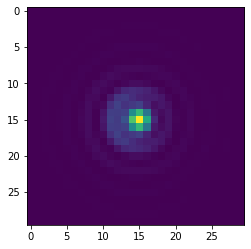

In [9]:
plt.imshow(data[...,2,0])

In [10]:
model_retrieved = AberratedIncoherentPSF(
                 pol_analyzer='quarter2pol',
                 angle_list=np.arange(angle_i,angle_f+angle_step,angle_step),
                 aperture_size=numerical_aperture / nf, 
                 computation_size=wavelength*magnification/(cam_pixel_size*nf), 
                 N_pts=128, 
                 ni=1.33, 
                 nf=1.518, 
                 delta=0.1,
                 jmax=[15]*5, 
                 index_convention='fringe'
                 )

In [11]:
lr = 1e-2
n_epochs = 1000

loss_fn = nn.MSELoss(reduction='mean')
# optimizer = optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(
    model_retrieved.parameters(), 
    lr=lr
)
loss_evol =[]
for epoch in range(n_epochs):
    # What is this?!?
    model_retrieved.train()

    # No more manual prediction!
    # yhat = a + b * x_tensor
    yhat = model_retrieved(z_list, 30)
    
    loss = loss_fn(data, yhat)
    loss_evol += [loss.item()]
    loss.backward()    
    optimizer.step()
    optimizer.zero_grad()
    if epoch%100==0:
        print(epoch)
    


0
100
200
300
400
500
600
700
800
900


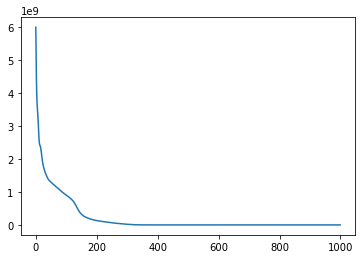

In [20]:
plt.plot((loss_evol))

In [34]:
yhat.shape

torch.Size([30, 30, 7, 6])

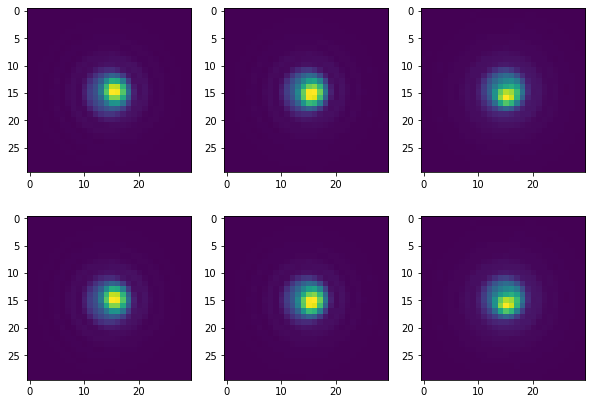

In [13]:
pdiv_ind = 1
zdiv_mid_ind = int((zf-zi)/z_step//2)
fig, ax = plt.subplots(2,3,figsize=(10,7))
for ind in range(3):
    ax[0,ind].imshow(data[...,zdiv_mid_ind-1+ind,pdiv_ind])
    ax[1,ind].imshow(yhat.detach().numpy()[...,zdiv_mid_ind-1+ind,pdiv_ind])

In [14]:
ux, uy = xy_mesh(2, computation_size/N_pts)
N_p = ux.shape[0]
dummy_input = torch.zeros((N_p,N_p,2,2), dtype=torch.cfloat)
dummy_input[...,0,0]=1
dummy_input[...,1,1]=1

In [15]:
with torch.no_grad():
    model_retrieved.aberrations.eval()
    pupil_ret = model_retrieved.aberrations(dummy_input)
with torch.no_grad():
    model_measured.aberrations.eval()
    pupil = model_measured.window(dummy_input)

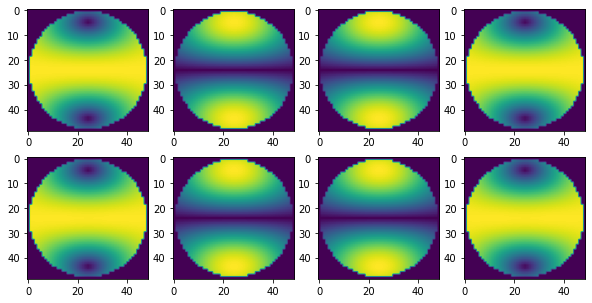

In [16]:
fig, ax = plt.subplots(2,4,figsize=(10,5))
for inx in range(2):
    for iny in range(2):
        ax[0,inx+2*iny].imshow(np.abs(pupil[...,inx,iny]))
        ax[1,inx+2*iny].imshow(np.abs(pupil_ret[...,inx,iny]))

In [17]:
model_retrieved.state_dict()

OrderedDict([('source.delta', tensor(0.0993)),
             ('aberrations.c_q',
              tensor([[ 2.5587e-01, -8.4264e-05,  5.6779e-06, -3.8320e-01,  5.3332e-05,
                       -1.0736e-06,  7.0082e-05,  1.1852e-05,  3.4616e-02, -1.4492e-05,
                       -1.8886e-07,  2.5309e-05, -1.3020e-06, -6.1233e-06,  1.6087e-05],
                      [-3.5198e-06,  1.7422e-06, -8.7256e-01, -9.7723e-07,  1.9497e-06,
                       -8.8958e-05, -2.1919e-06,  1.5571e-01, -7.3232e-07, -1.6692e-06,
                        5.7440e-05,  7.8040e-07,  1.3176e-04, -1.0058e-06, -7.0998e-03],
                      [ 1.8859e-06, -9.5571e-07,  1.6952e-06,  1.7348e-06,  4.7872e-07,
                        4.9139e-05, -3.0582e-07, -1.1723e-04, -1.7274e-06,  2.1792e-06,
                       -2.2916e-05,  1.0041e-07, -1.1935e-05, -2.2135e-06,  1.1837e-04],
                      [ 7.9040e-05, -8.7267e-01, -4.2953e-07,  9.6855e-06, -9.0325e-05,
                       -2.8184e-06,  

In [18]:
model_retrieved.state_dict()

OrderedDict([('source.delta', tensor(0.0993)),
             ('aberrations.c_q',
              tensor([[ 2.5587e-01, -8.4264e-05,  5.6779e-06, -3.8320e-01,  5.3332e-05,
                       -1.0736e-06,  7.0082e-05,  1.1852e-05,  3.4616e-02, -1.4492e-05,
                       -1.8886e-07,  2.5309e-05, -1.3020e-06, -6.1233e-06,  1.6087e-05],
                      [-3.5198e-06,  1.7422e-06, -8.7256e-01, -9.7723e-07,  1.9497e-06,
                       -8.8958e-05, -2.1919e-06,  1.5571e-01, -7.3232e-07, -1.6692e-06,
                        5.7440e-05,  7.8040e-07,  1.3176e-04, -1.0058e-06, -7.0998e-03],
                      [ 1.8859e-06, -9.5571e-07,  1.6952e-06,  1.7348e-06,  4.7872e-07,
                        4.9139e-05, -3.0582e-07, -1.1723e-04, -1.7274e-06,  2.1792e-06,
                       -2.2916e-05,  1.0041e-07, -1.1935e-05, -2.2135e-06,  1.1837e-04],
                      [ 7.9040e-05, -8.7267e-01, -4.2953e-07,  9.6855e-06, -9.0325e-05,
                       -2.8184e-06,  

In [ ]:
print(model_retrieved.state_dict())